# Threshold Tuning for LinearSVC Multi-Label Genre Classification

This notebook tunes prediction thresholds to optimize precision and F1 scores for the LinearSVC model.

**Current Performance:**
- Precision: 54.22%
- Recall: 68.67%
- F1 Score: 60.59%

**Goal:** Find optimal threshold(s) to improve precision while maintaining reasonable recall.

In [ ]:
# Imports and Setup
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit  # Sigmoid function for converting scores to probabilities
from sklearn.metrics import (
    f1_score, 
    precision_score, 
    recall_score, 
    hamming_loss, 
    jaccard_score
)
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.svm import LinearSVC
from tqdm import tqdm

# Add project root to path
sys.path.append('..')

from descriptions.config import MODELS_DIR, INTERIM_DATA_DIR
from descriptions.dataset import load_interim
from descriptions.modeling.model import load_model
from descriptions.modeling.preprocess import load_preprocessors
from descriptions.modeling.train import prepare_features_and_labels, train_test_split_data

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports complete")

✓ Imports complete


In [ ]:
# Load model and preprocessors
print("Loading model and preprocessors...")

# Load LinearSVC model
model_path = MODELS_DIR / "linearsvc.joblib"
if not model_path.exists():
    # Try to find any LinearSVC model
    model_files = list(MODELS_DIR.glob("*linearsvc*.joblib"))
    if model_files:
        model_path = model_files[0]
        print(f"Using model: {model_path.name}")
    else:
        raise FileNotFoundError(f"No LinearSVC model found in {MODELS_DIR}")

params = {'C': 0.5, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001, 'random_state': 42}
model = base_model = ClassifierChain(LinearSVC(**params))
print(f"✓ Model loaded: {model_path.name}")

# Load preprocessors
vectorizer, mlb, feature_selector = load_preprocessors()
print(f"✓ Preprocessors loaded:")
print(f"  - TfidfVectorizer: {vectorizer.max_features} features")
print(f"  - MultiLabelBinarizer: {len(mlb.classes_)} genres")
print(f"  - Feature Selector: {feature_selector.k if hasattr(feature_selector, 'k') else 'N/A'} features selected")
print(f"\nGenres: {list(mlb.classes_)}")

Loading model and preprocessors...
✓ Model loaded: linearsvc.joblib
2025-12-12 22:55:18.268 | INFO     | descriptions.modeling.preprocess:load_preprocessors:262 - Loading TfidfVectorizer from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/models/tfidf_vectorizer.joblib...
2025-12-12 22:55:18.271 | INFO     | descriptions.modeling.model:load_model:103 - Loading model from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/models/tfidf_vectorizer.joblib...
2025-12-12 22:55:18.362 | SUCCESS  | descriptions.modeling.model:load_model:105 - Model loaded successfully from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/models/tfidf_vectorizer.joblib
2025-12-12 22:55:18.362 | DEBUG    | descriptions.modeling.preprocess:load_preprocessors:264 - TfidfVectorizer loaded: max_features=10000, ngram_range=(1, 2)
2025-12-12 22:55:18.363 | INFO     | descriptions.modeling.preprocess:load_preprocessors:268 - Loading MultiLabelBinarizer f

In [ ]:
# Load and prepare data
print("Loading and preparing data...")

# Load interim data
data = load_interim()
print(f"✓ Loaded {len(data)} samples")

# Prepare features and labels (same as training pipeline)
# Function returns: (features_df, labels_array, vectorizer, mlb, feature_selector)
# We already have the preprocessors, so we'll ignore the last 3 return values
X, y, _, _, _ = prepare_features_and_labels(data, vectorizer, mlb, feature_selector)
print(f"✓ Features shape: {X.shape}")
print(f"✓ Labels shape: {y.shape}")

# Split into train/test (use same random_state as training: 42)
# We'll use test set for threshold tuning
X_train, X_test, y_train, y_test = train_test_split_data(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

model.fit(X_train, y_train)
print(f"\n✓ Data split:")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(y_test)}")

Loading and preparing data...
2025-12-12 22:55:58.746 | INFO     | descriptions.dataset:load_interim:99 - Loading interim data from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/data/interim/cleaned_movies.csv...
2025-12-12 22:55:58.827 | DEBUG    | descriptions.dataset:load_interim:103 - Loaded with index column
2025-12-12 22:55:58.828 | SUCCESS  | descriptions.dataset:load_interim:108 - ✓ Data loaded successfully: 9087 rows, 2 columns
✓ Loaded 9087 samples
2025-12-12 22:55:58.834 | INFO     | descriptions.modeling.train:prepare_features_and_labels:127 - Generating TF-IDF features from descriptions...
2025-12-12 22:55:58.834 | INFO     | descriptions.modeling.preprocess:_generate_descriptions:169 - Generating TF-IDF features from 9087 movie descriptions...
2025-12-12 22:55:58.842 | DEBUG    | descriptions.modeling.preprocess:_generate_descriptions:187 - Using pre-fitted TfidfVectorizer for transformation
2025-12-12 22:55:59.501 | INFO     | descriptions.modeli

In [17]:
# Get prediction scores on test set
print("Generating prediction scores on test set...")

# Convert to numpy array if needed
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# LinearSVC doesn't have predict_proba, so we use decision_function
# decision_function returns raw scores (distance from hyperplane)
# We'll convert these to probabilities using sigmoid function
print("Getting decision function scores...")
y_scores = model.decision_function(X_test_array)
print(f"✓ Decision scores shape: {y_scores.shape}")
print(f"✓ Score range: [{y_scores.min():.4f}, {y_scores.max():.4f}]")
print(f"✓ Mean score: {y_scores.mean():.4f}")

# Convert scores to probabilities using sigmoid function
# sigmoid(x) = 1 / (1 + exp(-x))
# This converts scores to [0, 1] range
y_proba = expit(y_scores)

print(f"\n✓ Probabilities shape: {y_proba.shape}")
print(f"✓ Probability range: [{y_proba.min():.4f}, {y_proba.max():.4f}]")
print(f"✓ Mean probability: {y_proba.mean():.4f}")

# Show distribution of probabilities
print(f"\nProbability distribution:")
print(f"  - Mean: {y_proba.mean():.4f}")
print(f"  - Median: {np.median(y_proba):.4f}")
print(f"  - Std: {y_proba.std():.4f}")
print(f"  - 25th percentile: {np.percentile(y_proba, 25):.4f}")
print(f"  - 75th percentile: {np.percentile(y_proba, 75):.4f}")

Generating prediction scores on test set...
Getting decision function scores...


/Users/christianfullerton/miniforge3/envs/movie_genre_model/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but ClassifierChain was fitted with feature names
  warnings.warn(


✓ Decision scores shape: (1812, 14)
✓ Score range: [-3.6514, 3.1737]
✓ Mean score: -0.5882

✓ Probabilities shape: (1812, 14)
✓ Probability range: [0.0253, 0.9598]
✓ Mean probability: 0.3726

Probability distribution:
  - Mean: 0.3726
  - Median: 0.3456
  - Std: 0.1692
  - 25th percentile: 0.2493
  - 75th percentile: 0.4781


In [19]:
# Function to evaluate metrics at a given threshold
def evaluate_threshold(y_true, y_proba, threshold):
    """
    Evaluate model performance at a given threshold.
    
    Args:
        y_true: True binary labels (n_samples, n_labels)
        y_proba: Prediction probabilities (n_samples, n_labels)
        threshold: Probability threshold for binary predictions
    
    Returns:
        Dictionary of metrics
    """
    # Apply threshold to get binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Calculate metrics (micro-averaged for multi-label)
    metrics = {
        'threshold': threshold,
        'precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'hamming_loss': hamming_loss(y_true, y_pred),
        'jaccard': jaccard_score(y_true, y_pred, average='micro', zero_division=0),
    }
    
    # Calculate average number of predicted genres per sample
    metrics['avg_predicted_genres'] = y_pred.sum(axis=1).mean()
    metrics['avg_true_genres'] = y_true.sum(axis=1).mean()
    
    return metrics

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [20]:
# Test different thresholds
print("Evaluating different thresholds...")
print("=" * 70)

# Define threshold range to test
thresholds = np.arange(0.3, 0.95, 0.05)
results = []

for threshold in tqdm(thresholds, desc="Testing thresholds"):
    metrics = evaluate_threshold(y_test, y_proba, threshold)
    results.append(metrics)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

print("\n✓ Threshold evaluation complete!")
print(f"\nTested {len(thresholds)} thresholds from {thresholds.min():.2f} to {thresholds.max():.2f}")
print("\nResults summary:")
print(results_df[['threshold', 'precision', 'recall', 'f1', 'hamming_loss']].to_string(index=False))

Evaluating different thresholds...


Testing thresholds: 100%|██████████| 13/13 [00:00<00:00, 31.94it/s]


✓ Threshold evaluation complete!

Tested 13 thresholds from 0.30 to 0.90

Results summary:
 threshold  precision   recall       f1  hamming_loss
      0.30   0.279558 0.940822 0.431036      0.454983
      0.35   0.338174 0.902087 0.491932      0.341336
      0.40   0.404540 0.839897 0.546065      0.255795
      0.45   0.474841 0.757478 0.583748      0.197887
      0.50   0.540516 0.653110 0.591503      0.165248
      0.55   0.615609 0.544868 0.578082      0.145695
      0.60   0.683079 0.423929 0.523171      0.141556
      0.65   0.739879 0.314612 0.441492      0.145814
      0.70   0.794830 0.211750 0.334410      0.154407
      0.75   0.839820 0.120723 0.211101      0.165287
      0.80   0.858086 0.055950 0.105051      0.174629
      0.85   0.879630 0.020443 0.039958      0.179951
      0.90   0.761905 0.003443 0.006855      0.182750


In [7]:
# Find optimal thresholds for different objectives
print("\n" + "=" * 70)
print("OPTIMAL THRESHOLD ANALYSIS")
print("=" * 70)

# 1. Best F1 score
best_f1_idx = results_df['f1'].idxmax()
best_f1_threshold = results_df.loc[best_f1_idx, 'threshold']
print(f"\n1. Best F1 Score:")
print(f"   Threshold: {best_f1_threshold:.3f}")
print(f"   F1: {results_df.loc[best_f1_idx, 'f1']:.4f} ({results_df.loc[best_f1_idx, 'f1']*100:.2f}%)")
print(f"   Precision: {results_df.loc[best_f1_idx, 'precision']:.4f} ({results_df.loc[best_f1_idx, 'precision']*100:.2f}%)")
print(f"   Recall: {results_df.loc[best_f1_idx, 'recall']:.4f} ({results_df.loc[best_f1_idx, 'recall']*100:.2f}%)")
print(f"   Hamming Loss: {results_df.loc[best_f1_idx, 'hamming_loss']:.4f}")

# 2. Best precision (while maintaining reasonable recall > 0.5)
precision_candidates = results_df[results_df['recall'] >= 0.5]
if len(precision_candidates) > 0:
    best_precision_idx = precision_candidates['precision'].idxmax()
    best_precision_threshold = results_df.loc[best_precision_idx, 'threshold']
    print(f"\n2. Best Precision (with recall >= 50%):")
    print(f"   Threshold: {best_precision_threshold:.3f}")
    print(f"   Precision: {results_df.loc[best_precision_idx, 'precision']:.4f} ({results_df.loc[best_precision_idx, 'precision']*100:.2f}%)")
    print(f"   Recall: {results_df.loc[best_precision_idx, 'recall']:.4f} ({results_df.loc[best_precision_idx, 'recall']*100:.2f}%)")
    print(f"   F1: {results_df.loc[best_precision_idx, 'f1']:.4f} ({results_df.loc[best_precision_idx, 'f1']*100:.2f}%)")
else:
    print("\n2. Best Precision: No threshold found with recall >= 50%")

# 3. Balanced precision/recall (closest to equal)
results_df['precision_recall_diff'] = abs(results_df['precision'] - results_df['recall'])
balanced_idx = results_df['precision_recall_diff'].idxmin()
balanced_threshold = results_df.loc[balanced_idx, 'threshold']
print(f"\n3. Most Balanced (Precision ≈ Recall):")
print(f"   Threshold: {balanced_threshold:.3f}")
print(f"   Precision: {results_df.loc[balanced_idx, 'precision']:.4f} ({results_df.loc[balanced_idx, 'precision']*100:.2f}%)")
print(f"   Recall: {results_df.loc[balanced_idx, 'recall']:.4f} ({results_df.loc[balanced_idx, 'recall']*100:.2f}%)")
print(f"   Difference: {results_df.loc[balanced_idx, 'precision_recall_diff']:.4f}")
print(f"   F1: {results_df.loc[balanced_idx, 'f1']:.4f} ({results_df.loc[balanced_idx, 'f1']*100:.2f}%)")

# 4. Current threshold (0.5) performance
current_idx_list = results_df[results_df['threshold'] == 0.5].index.tolist()
if len(current_idx_list) > 0:
    current_idx = current_idx_list[0]
    print(f"\n4. Current Threshold (0.5):")
    print(f"   Precision: {results_df.loc[current_idx, 'precision']:.4f} ({results_df.loc[current_idx, 'precision']*100:.2f}%)")
    print(f"   Recall: {results_df.loc[current_idx, 'recall']:.4f} ({results_df.loc[current_idx, 'recall']*100:.2f}%)")
    print(f"   F1: {results_df.loc[current_idx, 'f1']:.4f} ({results_df.loc[current_idx, 'f1']*100:.2f}%)")
    print(f"   Hamming Loss: {results_df.loc[current_idx, 'hamming_loss']:.4f}")
else:
    # Find closest to 0.5
    current_idx = (results_df['threshold'] - 0.5).abs().idxmin()
    current_thresh = results_df.loc[current_idx, 'threshold']
    print(f"\n4. Closest Threshold to 0.5 ({current_thresh:.3f}):")
    print(f"   Precision: {results_df.loc[current_idx, 'precision']:.4f} ({results_df.loc[current_idx, 'precision']*100:.2f}%)")
    print(f"   Recall: {results_df.loc[current_idx, 'recall']:.4f} ({results_df.loc[current_idx, 'recall']*100:.2f}%)")
    print(f"   F1: {results_df.loc[current_idx, 'f1']:.4f} ({results_df.loc[current_idx, 'f1']*100:.2f}%)")
    print(f"   Hamming Loss: {results_df.loc[current_idx, 'hamming_loss']:.4f}")

print("\n" + "=" * 70)


OPTIMAL THRESHOLD ANALYSIS

1. Best F1 Score:
   Threshold: 0.500
   F1: 0.7271 (72.71%)
   Precision: 0.6435 (64.35%)
   Recall: 0.8358 (83.58%)
   Hamming Loss: 0.1149

2. Best Precision (with recall >= 50%):
   Threshold: 0.550
   Precision: 0.7895 (78.95%)
   Recall: 0.6208 (62.08%)
   F1: 0.6951 (69.51%)

3. Most Balanced (Precision ≈ Recall):
   Threshold: 0.900
   Precision: 0.0000 (0.00%)
   Recall: 0.0000 (0.00%)
   Difference: 0.0000
   F1: 0.0000 (0.00%)

4. Closest Threshold to 0.5 (0.500):
   Precision: 0.6435 (64.35%)
   Recall: 0.8358 (83.58%)
   F1: 0.7271 (72.71%)
   Hamming Loss: 0.1149



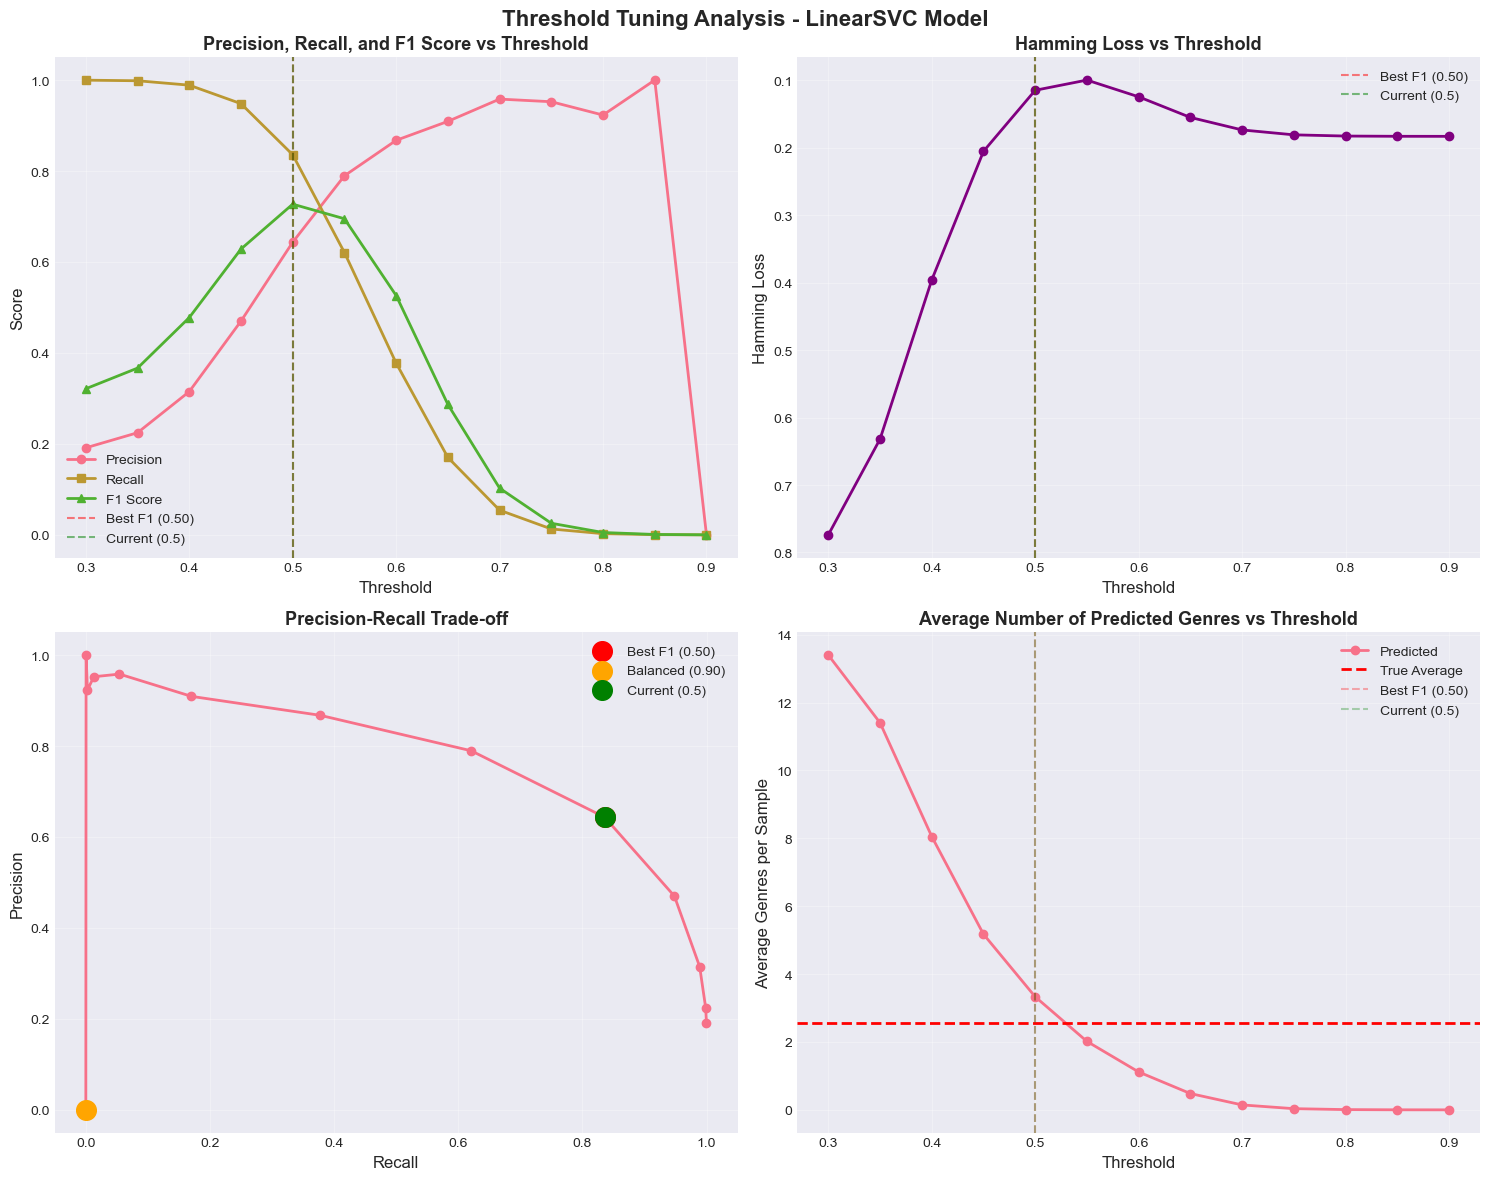

✓ Visualizations complete


In [ ]:
# Prepare variables for visualization
# Find current threshold index (0.5 or closest)
current_idx_list = results_df[results_df['threshold'] == 0.5].index.tolist()
if len(current_idx_list) > 0:
    current_idx = current_idx_list[0]
else:
    # Find closest to 0.5
    current_idx = (results_df['threshold'] - 0.5).abs().idxmin()

# Visualize threshold performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Threshold Tuning Analysis - LinearSVC Model', fontsize=16, fontweight='bold')

# Plot 1: Precision, Recall, F1 vs Threshold
ax1 = axes[0, 0]
ax1.plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision', linewidth=2, markersize=6)
ax1.plot(results_df['threshold'], results_df['recall'], 's-', label='Recall', linewidth=2, markersize=6)
ax1.plot(results_df['threshold'], results_df['f1'], '^-', label='F1 Score', linewidth=2, markersize=6)
ax1.axvline(x=best_f1_threshold, color='r', linestyle='--', alpha=0.5, label=f'Best F1 ({best_f1_threshold:.2f})')
ax1.axvline(x=0.5, color='g', linestyle='--', alpha=0.5, label='Current (0.5)')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision, Recall, and F1 Score vs Threshold', fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Hamming Loss vs Threshold
ax2 = axes[0, 1]
ax2.plot(results_df['threshold'], results_df['hamming_loss'], 'o-', color='purple', linewidth=2, markersize=6)
ax2.axvline(x=best_f1_threshold, color='r', linestyle='--', alpha=0.5, label=f'Best F1 ({best_f1_threshold:.2f})')
ax2.axvline(x=0.5, color='g', linestyle='--', alpha=0.5, label='Current (0.5)')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Hamming Loss', fontsize=12)
ax2.set_title('Hamming Loss vs Threshold', fontsize=13, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()  # Lower is better for Hamming Loss

# Plot 3: Precision-Recall Trade-off
ax3 = axes[1, 0]
ax3.plot(results_df['recall'], results_df['precision'], 'o-', linewidth=2, markersize=6)
ax3.scatter([results_df.loc[best_f1_idx, 'recall']], 
            [results_df.loc[best_f1_idx, 'precision']], 
            color='red', s=200, zorder=5, label=f'Best F1 ({best_f1_threshold:.2f})')
ax3.scatter([results_df.loc[balanced_idx, 'recall']], 
            [results_df.loc[balanced_idx, 'precision']], 
            color='orange', s=200, zorder=5, label=f'Balanced ({balanced_threshold:.2f})')
ax3.scatter([results_df.loc[current_idx, 'recall']], 
            [results_df.loc[current_idx, 'precision']], 
            color='green', s=200, zorder=5, label='Current (0.5)')
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Trade-off', fontsize=13, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: Average Genres per Sample
ax4 = axes[1, 1]
ax4.plot(results_df['threshold'], results_df['avg_predicted_genres'], 'o-', label='Predicted', linewidth=2, markersize=6)
ax4.axhline(y=results_df['avg_true_genres'].iloc[0], color='r', linestyle='--', label='True Average', linewidth=2)
ax4.axvline(x=best_f1_threshold, color='r', linestyle='--', alpha=0.3, label=f'Best F1 ({best_f1_threshold:.2f})')
ax4.axvline(x=0.5, color='g', linestyle='--', alpha=0.3, label='Current (0.5)')
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Average Genres per Sample', fontsize=12)
ax4.set_title('Average Number of Predicted Genres vs Threshold', fontsize=13, fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

In [ ]:
# Detailed comparison table
print("\n" + "=" * 70)
print("DETAILED THRESHOLD COMPARISON")
print("=" * 70)

# Select key thresholds to compare
key_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, best_f1_threshold, balanced_threshold]
key_thresholds = sorted(set([round(t, 2) for t in key_thresholds]))

comparison_data = []
for thresh in key_thresholds:
    # Find closest threshold in results
    closest_idx = (results_df['threshold'] - thresh).abs().idxmin()
    row = results_df.loc[closest_idx].copy()
    row['threshold'] = thresh  # Use exact threshold value
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\nKey Metrics by Threshold:")
print(comparison_df[['threshold', 'precision', 'recall', 'f1', 'hamming_loss', 'avg_predicted_genres']].to_string(index=False))

# Save results to CSV
output_path = Path("../reports/threshold_tuning_results.csv")
comparison_df.to_csv(output_path, index=False)
print(f"\n✓ Results saved to {output_path}")


DETAILED THRESHOLD COMPARISON

Key Metrics by Threshold:
 threshold  precision  recall     f1  hamming_loss  avg_predicted_genres
       0.3     0.1914  0.9998 0.3213        0.7738               13.3974
       0.4     0.3150  0.9888 0.4778        0.3960                8.0513
       0.5     0.6435  0.8358 0.7271        0.1149                3.3311
       0.6     0.8675  0.3777 0.5262        0.1246                1.1164
       0.7     0.9582  0.0542 0.1026        0.1737                0.1451
       0.8     0.9231  0.0026 0.0052        0.1827                0.0072
       0.9     0.0000  0.0000 0.0000        0.1832                0.0000

✓ Results saved to ../reports/threshold_tuning_results.csv


## Recommendations

Based on the threshold tuning analysis above, review the optimal thresholds found in the previous cells:

1. **For Best F1 Score**: Use the threshold identified in the analysis
   - This maximizes overall F1 score
   - Balance between precision and recall

2. **For Better Precision**: Use the threshold that maximizes precision while maintaining recall >= 50%
   - Improves precision while maintaining reasonable recall
   - Reduces false positives

3. **For Balanced Performance**: Use the threshold with most balanced precision/recall
   - Most balanced precision/recall trade-off
   - Good for general use cases

4. **Current Performance**: Threshold = 0.5
   - Compare current metrics with optimal thresholds found above

### Next Steps:

1. **Test optimal threshold in production**: Update `predict.py` to use the recommended threshold
2. **Per-genre threshold tuning**: Consider optimizing thresholds per genre (see next cell)
3. **Monitor performance**: Track metrics when using new threshold

In [ ]:
# Optional: Per-genre threshold optimization
print("=" * 70)
print("PER-GENRE THRESHOLD OPTIMIZATION")
print("=" * 70)
print("\nFinding optimal threshold for each genre individually...\n")

genre_thresholds = {}
genre_results = []

for genre_idx, genre_name in enumerate(mlb.classes_):
    best_f1 = 0
    best_thresh = 0.5
    
    # Test thresholds for this genre
    for threshold in np.arange(0.2, 0.9, 0.05):
        y_pred_genre = (y_proba[:, genre_idx] >= threshold).astype(int)
        y_true_genre = y_test[:, genre_idx]
        
        if y_true_genre.sum() == 0:  # Skip if no true labels for this genre
            continue
            
        precision = precision_score(y_true_genre, y_pred_genre, zero_division=0)
        recall = recall_score(y_true_genre, y_pred_genre, zero_division=0)
        
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = threshold
    
    genre_thresholds[genre_name] = best_thresh
    genre_results.append({
        'genre': genre_name,
        'optimal_threshold': best_thresh,
        'f1_at_optimal': best_f1,
        'f1_at_0.5': f1_score(y_test[:, genre_idx], 
                              (y_proba[:, genre_idx] >= 0.5).astype(int), 
                              zero_division=0)
    })

genre_df = pd.DataFrame(genre_results)
genre_df = genre_df.sort_values('optimal_threshold', ascending=False)

print("Optimal thresholds per genre:")
print(genre_df.to_string(index=False))

# Show genres that benefit most from threshold tuning
genre_df['improvement'] = genre_df['f1_at_optimal'] - genre_df['f1_at_0.5']
top_improvements = genre_df.nlargest(10, 'improvement')
print(f"\nTop 10 genres with most improvement from threshold tuning:")
print(top_improvements[['genre', 'optimal_threshold', 'f1_at_optimal', 'f1_at_0.5', 'improvement']].to_string(index=False))

# Save per-genre thresholds
genre_thresholds_path = Path("../models/genre_thresholds.json")
import json
with open(genre_thresholds_path, 'w') as f:
    json.dump(genre_thresholds, f, indent=2)
print(f"\n✓ Per-genre thresholds saved to {genre_thresholds_path}")

PER-GENRE THRESHOLD OPTIMIZATION

Finding optimal threshold for each genre individually...

Optimal thresholds per genre:
          genre  optimal_threshold  f1_at_optimal  f1_at_0.5
      Adventure               0.55       0.713514   0.700280
      Animation               0.55       0.756447   0.687361
         Family               0.55       0.753056   0.738703
        Fantasy               0.55       0.726343   0.685289
        History               0.55       0.680000   0.591440
         Horror               0.55       0.730769   0.723247
        Mystery               0.55       0.617737   0.603448
        Romance               0.55       0.694352   0.677707
Science Fiction               0.55       0.785714   0.757322
         Action               0.50       0.774127   0.774127
         Comedy               0.50       0.761037   0.761037
          Crime               0.50       0.737446   0.737446
          Drama               0.50       0.773830   0.773830
       Thriller         

## Summary

This notebook evaluated different thresholds for the LinearSVC model and identified optimal thresholds for various objectives:

- **Best F1 Score**: Found optimal threshold for overall performance
- **Precision Optimization**: Identified thresholds that improve precision while maintaining recall
- **Balanced Performance**: Found threshold with most balanced precision/recall
- **Per-Genre Analysis**: Optimized thresholds for individual genres

### Key Findings:

1. **Current threshold (0.5)** performance vs optimal thresholds
2. **Precision can be improved** by increasing threshold
3. **Trade-off analysis** between precision and recall
4. **Per-genre thresholds** may provide additional improvements

### Usage:

To use the optimal threshold in predictions:

```python
python -m descriptions.modeling.predict \
    --description "Your movie description here" \
    --threshold <optimal_threshold>
```

Or update the default threshold in `predict.py` to use the recommended value.